In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [7]:
sns.set_style("darkgrid")

In [8]:
plt.rcParams['figure.figsize'] = (16,8)

In [11]:
df = pd.read_csv('ACLBSL_2000-01-01_2021-12-31.csv')
df['Date'] = pd.to_datetime(df.Date)
# df = df[df['Date'] >= '2023-07-23']
df.head()

,S.N.,Date,Total Transactions,Total Traded Shares,Total Traded Amount,Max. Price,Min. Price,Close Price
0,1,2021-12-29,34,696.0,842596.0,1227.0,1205.0,1227.0
1,2,2021-12-28,48,1322.0,1575896.8,1227.0,1180.1,1227.0
2,3,2021-12-27,45,1023.0,1256329.0,1285.2,1204.0,1204.0
3,4,2021-12-26,43,2051.0,2510045.0,1239.8,1194.2,1238.8
4,5,2021-12-23,41,1153.0,1390142.0,1221.0,1181.1,1200.0


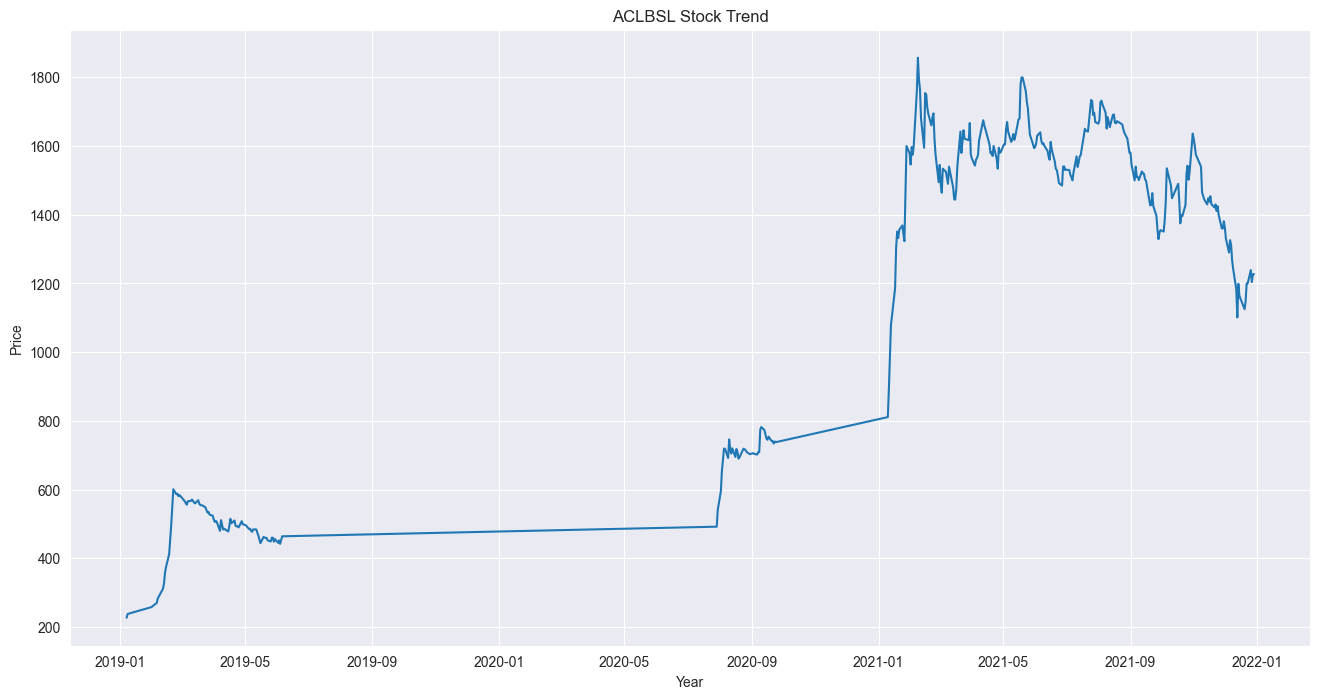

In [20]:
plt.plot(df["Date"], df["Close Price"])
plt.title("ACLBSL Stock Trend")
plt.xlabel("Year")
plt.ylabel("Price")
plt.show()


In [39]:
df = df[['Date', 'Close Price']]
df.head()

df.tail()

,Date,Close Price
350,2019-02-06,283.0
351,2019-02-05,270.0
352,2019-01-31,258.0
353,2019-01-08,238.0
354,2019-01-07,227.0


In [41]:
# Calculate the 'returns' column using .pct_change() after setting the index to 'Date'
df.set_index('Date', inplace=True)
df['returns'] = df['Close Price'].pct_change() * 100

# Drop the first row with NaN value in the 'returns' column
df.dropna(subset=['returns'], inplace=True)

# Reset the index if needed
df.reset_index(inplace=True)

df.head()

C:\Users\subed\AppData\Local\Temp\ipykernel_12500\249337901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['returns'] = df['Close Price'].pct_change() * 100
C:\Users\subed\AppData\Local\Temp\ipykernel_12500\249337901.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['returns'], inplace=True)


,index,Date,Close Price,returns
0,5,2021-12-20,1125.0,-2.003484
1,6,2021-12-16,1156.0,2.755556
2,7,2021-12-15,1165.0,0.778547
3,8,2021-12-14,1199.0,2.918455
4,9,2021-12-13,1101.1,-8.165138


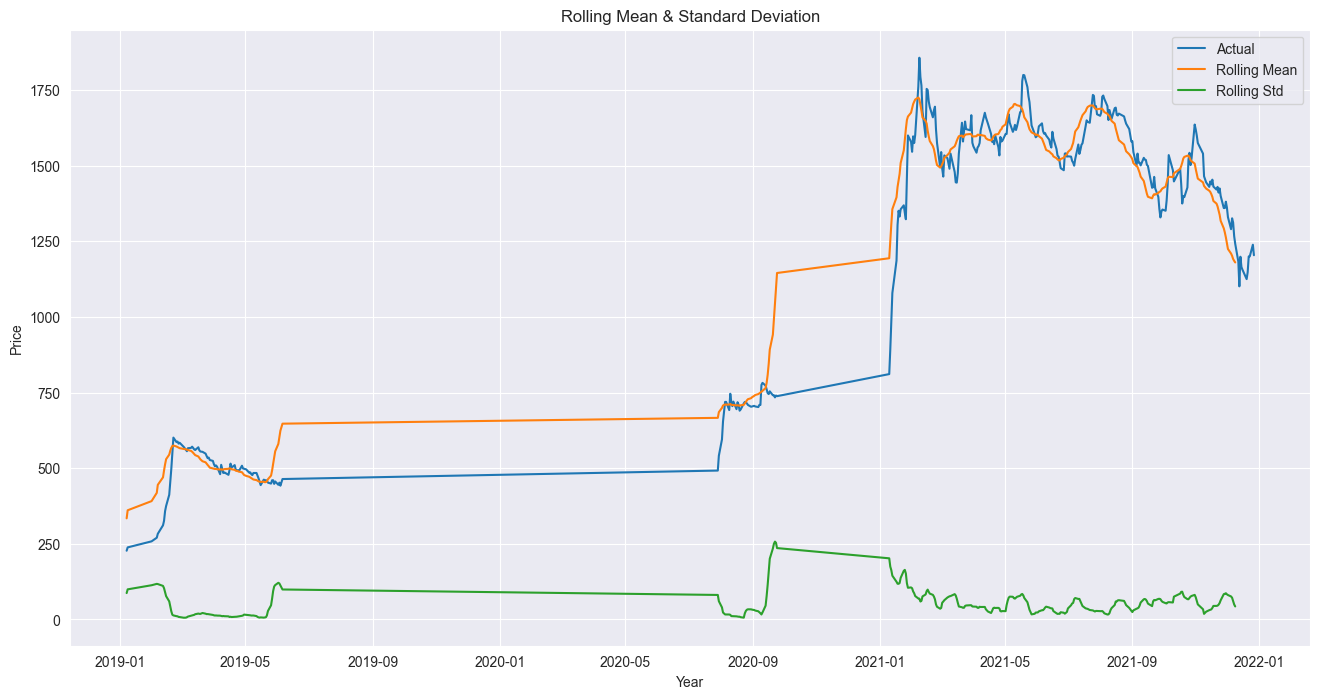

In [35]:
# High level overview of Closing price to see if it is stationary or not

rolling_mean = df['Close Price'].rolling(12).mean()
rolling_std = df['Close Price'].rolling(12).std()

plt.title('Rolling Mean & Standard Deviation')
plt.plot(df['Date'], df['Close Price'], label='Actual')
plt.plot(df['Date'], rolling_mean, label='Rolling Mean')
plt.plot(df['Date'], rolling_std, label='Rolling Std')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()